![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/SparkOCRVisualDocumentClassifier.ipynb)

# Visual Document Classifier

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()
os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.0.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
! pip install spark-ocr==$OCR_VERSION\+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

## Attention! Restart kernel after first run in order to use newly installed versions of some libraries

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [8]:
import pandas as pd
import numpy as np
import os

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
import sparkocr
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image
from sparkocr.metrics import score
import pkg_resources

# import sparknlp packages
from sparknlp.annotator import *
from sparknlp.base import *

from sparkocr.transformers import *
from pyspark import SparkConf

### Initialize Spark session

In [4]:
spark = sparkocr.start(secret=SPARK_OCR_SECRET, 
                       nlp_version=PUBLIC_VERSION
                       )

Spark version: 3.0.2
Spark NLP version: 3.3.4
Spark OCR version: 3.9.1



## Load test images

In [5]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/document_classification/')
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/usr/local/l...|2022-01-10 17:49:...|429583|[FF D8 FF E0 00 1...|
|file:/usr/local/l...|2022-01-10 17:49:...|412534|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+



## Display images


    Image #0:
    Origin: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/images/document_classification/letter.jpg
    Resolution: 72 dpi
    Width: 2400 px
    Height: 3150 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


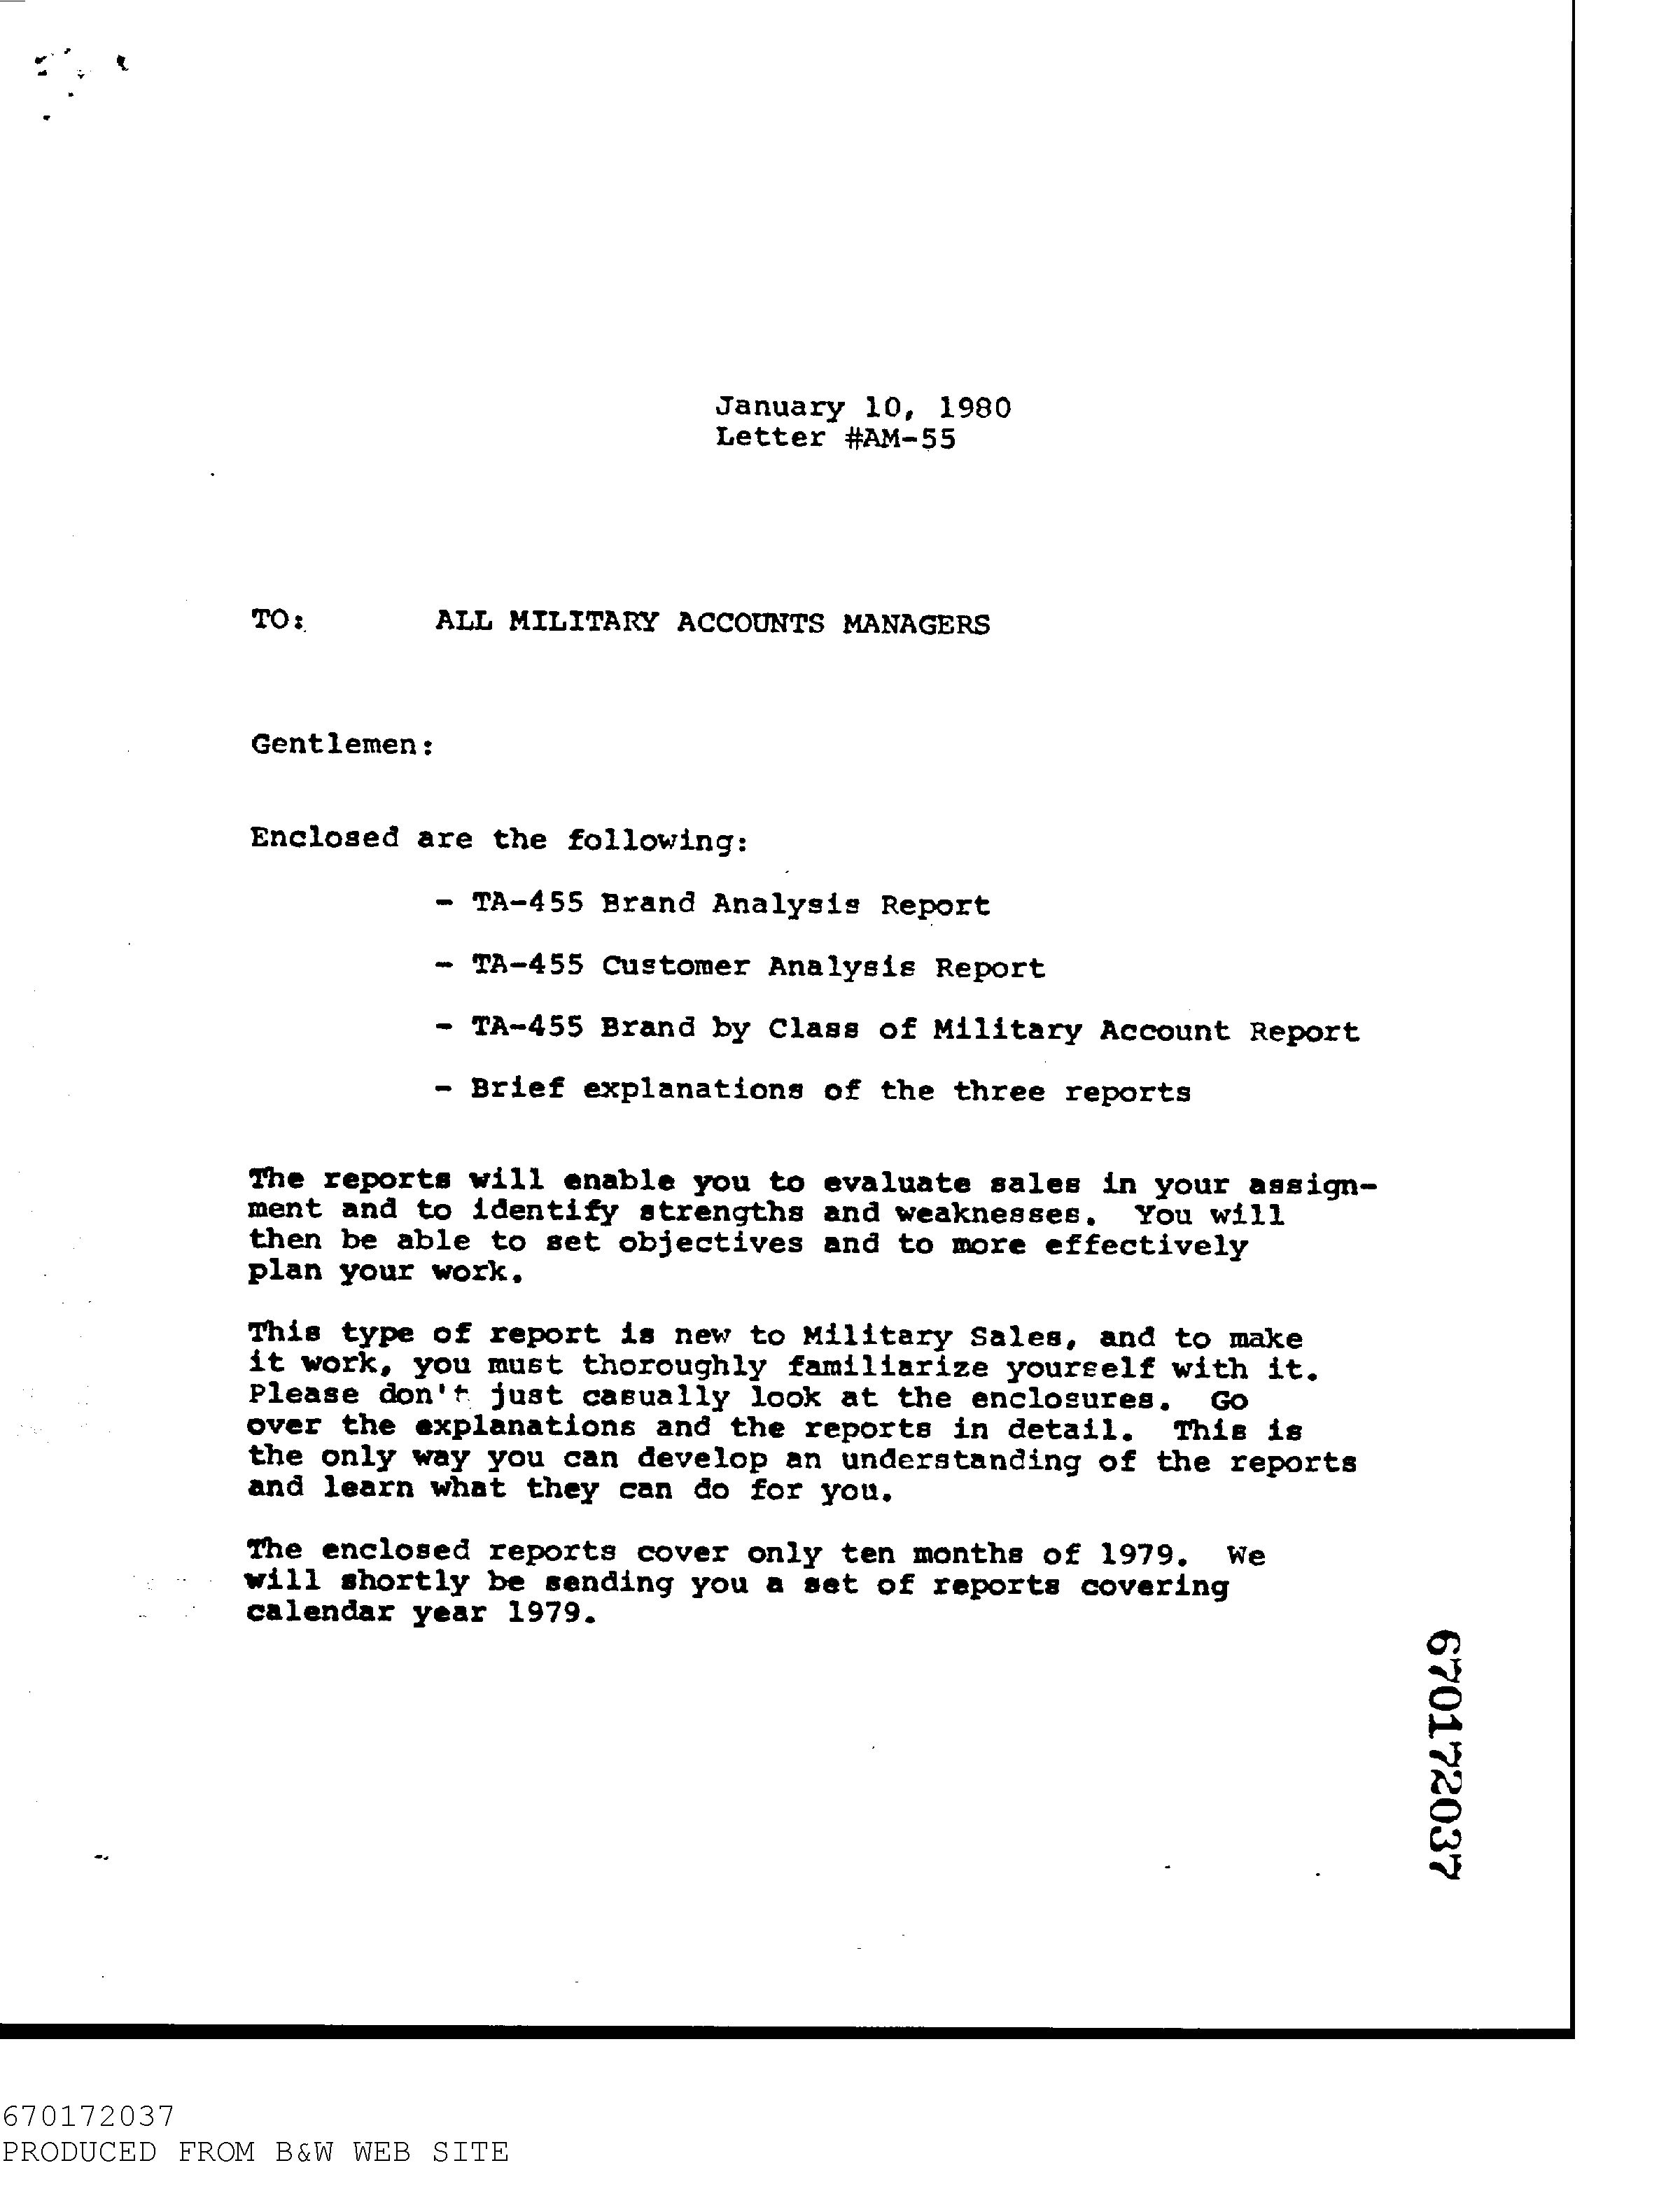


    Image #0:
    Origin: file:/usr/local/lib/python3.7/dist-packages/sparkocr/resources/ocr/images/document_classification/samplecv.jpg
    Resolution: 72 dpi
    Width: 2544 px
    Height: 3296 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


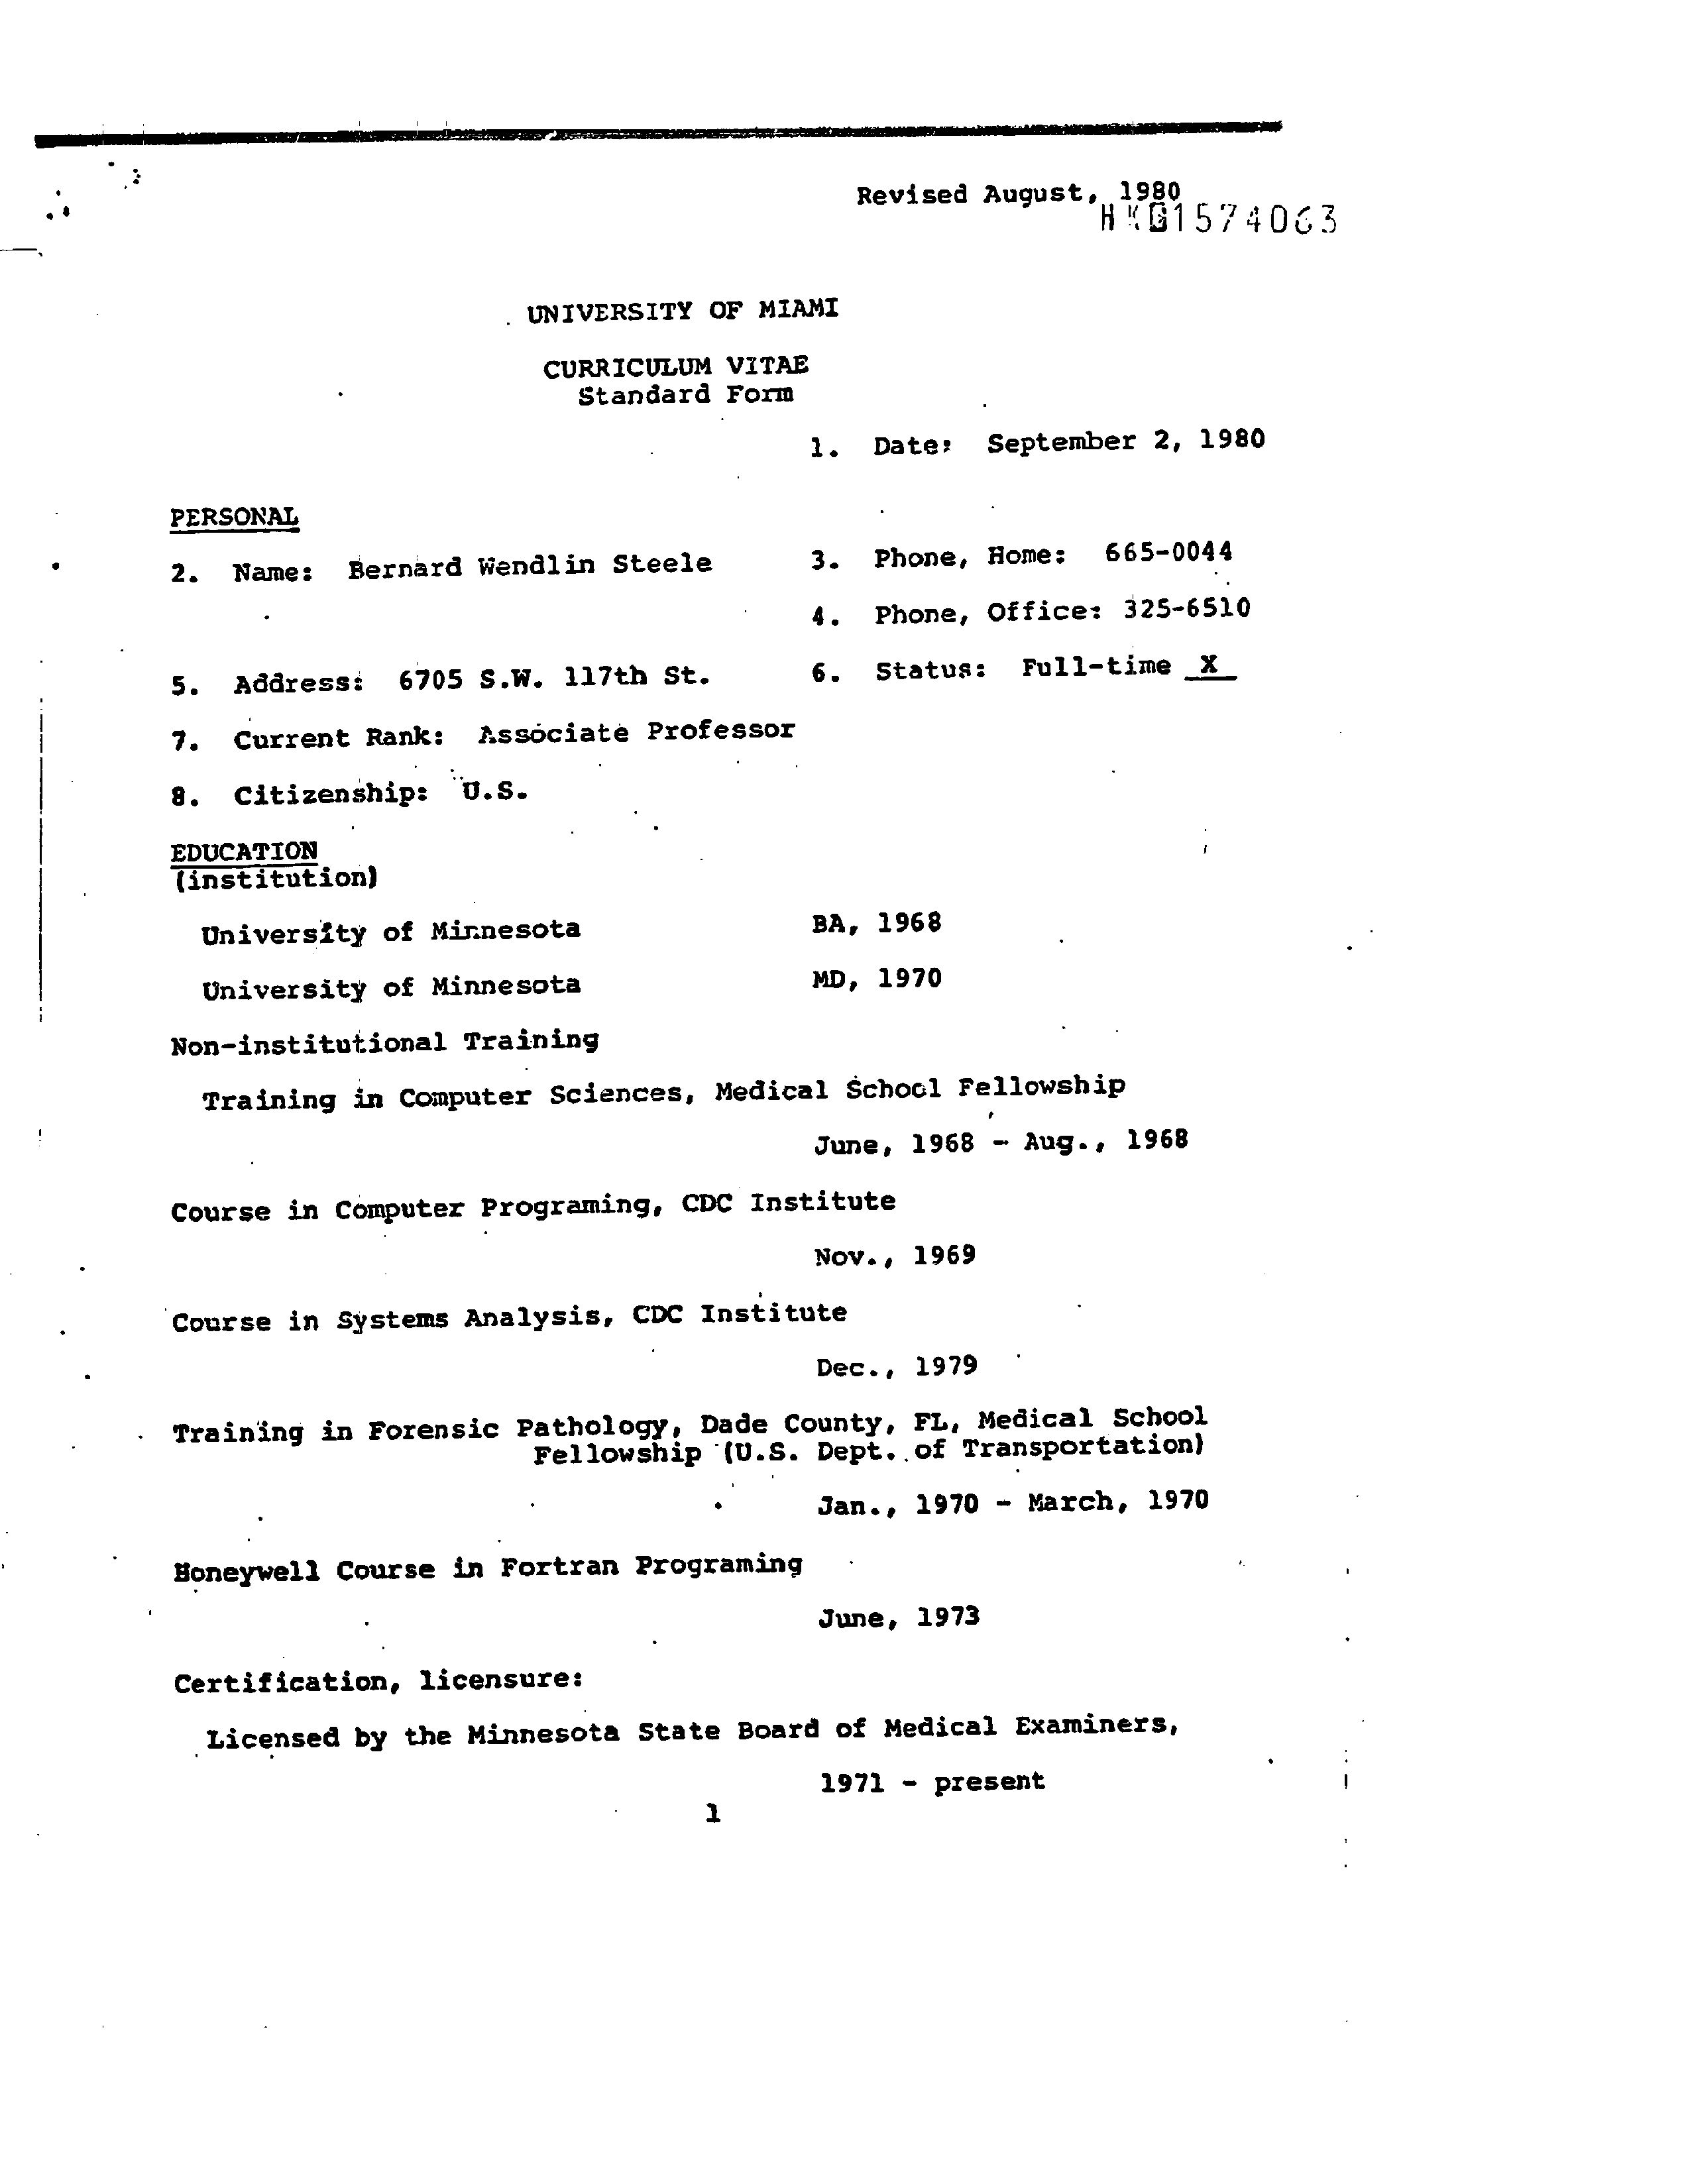

In [6]:
for item in BinaryToImage().transform(bin_df).select("image").collect():
    display_image(item.image)

### Define pipeline

In [10]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image")

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])


doc_classifier = VisualDocumentClassifier()\
    .pretrained("visual_document_classifier_tobacco3482", "en", "clinical/ocr") \
    .setInputCol("hocr")\
    .setLabelCol("label")\
    .setConfidenceCol("conf")

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    doc_classifier
])

visual_document_classifier_tobacco3482 download started this may take some time.
Approximate size to download 398.1 MB


## Call pipeline

In [11]:
results = pipeline.transform(bin_df)

## Show results

In [15]:
results['path']

Column<b'path'>

In [17]:
## as pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = F.split(results['path'], '/')
results = results.withColumn('filename', path_array.getItem(F.size(path_array)- 1)) \
       .select("filename", "label", "conf") \
       .show(truncate=False)

+------------+------+---------+
|filename    |label |conf     |
+------------+------+---------+
|letter.jpg  |Letter|0.9960775|
|samplecv.jpg|Resume|0.9914676|
+------------+------+---------+

